## Querying the RDF Weather dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DayLocator, DateFormatter
from SPARQLWrapper import SPARQLWrapper, JSON
import date

In [ ]:
pip install SPARQLWrapper

Note: you may need to restart the kernel to use updated packages.


In [ ]:
def sparql_to_dataframe(endpoint, query):
    """
    Convert SPARQL results into a Pandas DataFrame.
    Credit: https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()

    cols = results['head']['vars']
    out = []
    for row in results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)


endpoint = 'http://localhost:8890/sparql'

# Examples of queries 

#  Query 1 : Retrieve precipitations amount for period of times at a specific station

In [ ]:
query = '''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
prefix wep: <http://ns.inria.fr/meteo/ontology/property/>
prefix weo: <http://ns.inria.fr/meteo/ontology/>
prefix dct: <http://purl.org/dc/terms/>
prefix wdt: <http://www.wikidata.org/prop/direct/>

select ?datetimestamp (?vt as ?precipitation) where {
    ?obs a  <http://ns.inria.fr/meteo/ontology/MeteorologicalObservation> .
    ?obs sosa:observedProperty <http://ns.inria.fr/meteo/vocab/weatherproperty/precipitationAmount>.
    ?obs sosa:hasSimpleResult ?vt.
    ?obs sosa:resultTime ?datetimestamp.
    ?obs wep:madeByStation ?x .
    ?x rdfs:label ?n ;  weo:stationID ?stationID
    FILTER (?stationID = "07690")
    FILTER (?datetimestamp >= "2021-01-01T00:00:00"^^xsd:dateTime)
    FILTER (?datetimestamp < "2021-01-15T00:00:00"^^xsd:dateTime)}
    ORDER BY ?datetimestamp

'''


In [ ]:
%time df = sparql_to_dataframe(endpoint, query)
print(df.shape)

CPU times: user 4.9 ms, sys: 4.75 ms, total: 9.64 ms
Wall time: 64.3 ms
(444, 2)


## Visualise Results as a plot 

In [ ]:
df.precipitation = df.precipitation.astype(float)
df.datetimestamp = pd.to_datetime(df.datetimestamp)
df['date'] = [x.date() for x in df.datetimestamp]
df1 = df.groupby('date').mean('precipitation')

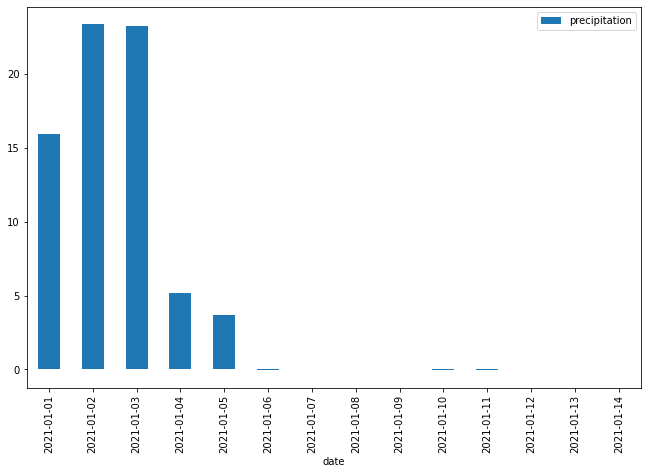

In [ ]:
fig, ax = plt.subplots(figsize=(11,7))
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%m-%d '))
df1.plot(ax=ax, kind='bar')
plt.show()

# Query 2 : Retrieve mean maximum and minimal temperature in Celsius over a period of time for a specific station

In [ ]:
query2 = '''
    #return mean temperature in Celsius for the station "07690" 
    PREFIX sosa: <http://www.w3.org/ns/sosa/>
    PREFIX qudt: <http://qudt.org/schema/qudt/>
    PREFIX wep: <http://ns.inria.fr/meteo/ontology/property/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX weo: <http://ns.inria.fr/meteo/ontology/>

    SELECT  ?datetimestamp ((?v - 273.15) as ?temperature_minimale_en_Celsius)  where {
        ?obs a  <http://ns.inria.fr/meteo/ontology/MeteorologicalObservation>;
        sosa:observedProperty
              <http://ns.inria.fr/meteo/vocab/weatherproperty/minAirTemperature> ;
        sosa:hasSimpleResult  ?v;
        wep:madeByStation ?station ;
        sosa:resultTime ?datetimestamp .
        ?station rdfs:label ?n ;  weo:stationID ?stationID
        FILTER (?stationID = "07690" )
        FILTER (?datetimestamp >= "2021-08-01T00:00:00"^^xsd:dateTime)
        FILTER (?datetimestamp < "2021-08-31T21:00:00"^^xsd:dateTime)
        } 
        ORDER BY(?datetimestamp)
'''
query3 = '''
    #return mean temperature in Celsius for the station "07690" 
    PREFIX sosa: <http://www.w3.org/ns/sosa/>
    PREFIX qudt: <http://qudt.org/schema/qudt/>
    PREFIX wep: <http://ns.inria.fr/meteo/ontology/property/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX weo: <http://ns.inria.fr/meteo/ontology/>

    SELECT  ?datetimestamp ((?v - 273.15) as ?temperature_maximale_en_Celsius)  where {
        ?obs a  <http://ns.inria.fr/meteo/ontology/MeteorologicalObservation>;
        sosa:observedProperty
              <http://ns.inria.fr/meteo/vocab/weatherproperty/maxAirTemperature> ;
        sosa:hasSimpleResult  ?v;
        wep:madeByStation ?station ;
        sosa:resultTime ?datetimestamp .
        ?station rdfs:label ?n ;  weo:stationID ?stationID
        FILTER (?stationID = "07690" )
        FILTER (?datetimestamp >= "2021-08-01T00:00:00"^^xsd:dateTime)
        FILTER (?datetimestamp < "2021-08-31T21:00:00"^^xsd:dateTime)
        
        } 
        ORDER BY(?datetimestamp)
'''

In [ ]:
df2 = sparql_to_dataframe(endpoint, query2)
df2['datetimestamp'] = pd.to_datetime(df2.datetimestamp, format='%Y-%m-%d')
df2['datetimestamp'] = [x.date() for x in df2.datetimestamp]

df2.temperature_minimale_en_Celsius= df2.temperature_minimale_en_Celsius.astype(float)
newdf2 = df2.groupby('datetimestamp').mean('temperature_minimale_en_Celsius')
newdf2

,temperature_minimale_en_Celsius
datetimestamp,
2021-08-01,22.25
2021-08-02,21.70
2021-08-03,20.10
2021-08-04,21.25
2021-08-05,19.40
2021-08-06,20.95
2021-08-07,21.00
2021-08-08,21.20
2021-08-09,21.20


In [ ]:
df3 = sparql_to_dataframe(endpoint, query3)
df3['datetimestamp'] = pd.to_datetime(df3.datetimestamp, format='%Y-%m-%d')
df3['datetimestamp'] = [x.date() for x in df3.datetimestamp]
df3.temperature_maximale_en_Celsius= df3.temperature_maximale_en_Celsius.astype(float)
newdf3 = df3.groupby('datetimestamp').mean('temperature_maximale_en_Celsius')
newdf3.head()


,temperature_maximale_en_Celsius
datetimestamp,
2021-08-01,29.1
2021-08-02,27.9
2021-08-03,25.4
2021-08-04,24.0
2021-08-05,24.8


In [ ]:
df = newdf3.join(newdf2)
df.head()

,temperature_maximale_en_Celsius,temperature_minimale_en_Celsius
datetimestamp,,
2021-08-01,29.1,22.25
2021-08-02,27.9,21.70
2021-08-03,25.4,20.10
2021-08-04,24.0,21.25
2021-08-05,24.8,19.40


## Visualise Results as a plot 

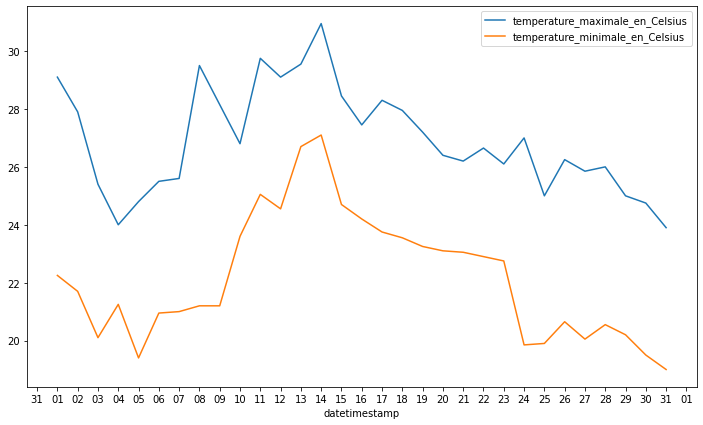

In [ ]:
#print(final_df.tail())
#print(final_df.shape)

fig, ax = plt.subplots(figsize=(12,7))
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d'))
df.plot(ax=ax)
plt.show()

# Query 2 : Retrieve the most close SYNOP station based on geospatial coordinates a place

In [ ]:
pip install folium

In [ ]:
query = '''
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX geosparql: <http://www.opengis.net/ont/geosparql#>
    PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
    PREFIX uom: <http://www.opengis.net/def/uom/OGC/1.0/>
    PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

    select  ?label ?x ?lat ?long ?coordinates ?distance where {
        ?x rdfs:label ?label .
        ?x geosparql:hasGeometry [ geosparql:asWKT ?coordinates].
        ?x geo:lat ?lat .
        ?x geo:long ?long .
        BIND (geof:distance(?coordinates, "Point(7.123055555 43.58)"^^geosparql:wktLiteral, uom:metre) as ?distance)      

    }
    ORDER BY ?distance
    LIMIT 1

'''

In [ ]:
df = sparql_to_dataframe(endpoint, query)

In [ ]:
df

,label,x,lat,long,coordinates,distance
0,NICE,http://ns.inria.fr/meteo/weatherstation/07690,43.648833,7.209,POINT(7.2090001106262 43.648834228516),10312.0


In [ ]:
import folium

In [ ]:
distance = str(float(df.distance)/1000)+" km" 
distance

station = df['label']


'0    NICE\nName: label, dtype: object'

In [ ]:
my_map = folium.Map(location=[43.58, 7.123055555],
                    zoom_start = 10)
long = df.long
lat = df.lat

coordinates = [[43.58, 7.123055555], [lat,long]]
folium.Marker([43.58, 7.123055555]).add_to(my_map)

folium.Marker([lat, long],
              icon=folium.Icon(color='green')).add_to(my_map)
folium.PolyLine(coordinates, popup = distance).add_to(my_map)

In [ ]:
my_map